In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
# !pip install mpi4py

In [5]:
def get_signal(a,b,c,d,e,f,g,h,j,k, n=2**3):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

In [77]:
np.random.seed(8)
signals = []
n = 2**4
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k,n=n))

new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20, n=n)
t = np.linspace(-20*2*np.pi, 20*2*np.pi, n)

## Algorithms

### MPI for cycle

In [80]:
times_mpi1_for = []
times_mpi2_for = []
times_mpi4_for = []
times_mpi6_for = []

In [7]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**4
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Writing shazam_for.py


In [8]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

2
9.810180150999997


In [9]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

2
9.733911133999982


In [10]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

2
10.296488771000014


In [11]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

2
10.702649521000012
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [81]:
times_mpi1_for.append(9.810180150999997)
times_mpi2_for.append(9.733911133999982)
times_mpi4_for.append(10.296488771000014)
times_mpi6_for.append(10.702649521000012)

In [12]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**5
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_for.py


In [13]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

86
17.783488887000004


In [14]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

86
17.979641979000007


In [15]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

86
18.458956867999973


In [16]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

86
19.432519290000016
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [82]:
times_mpi1_for.append(17.783488887000004)
times_mpi2_for.append(17.979641979000007)
times_mpi4_for.append(18.458956867999973)
times_mpi6_for.append(19.432519290000016)

In [17]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**6
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_for.py


In [18]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

57
33.82063869000001


In [19]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

57
35.374220955


In [20]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

57
35.555941400999984


In [21]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

57
36.268093498999974
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [83]:
times_mpi1_for.append(33.82063869000001)
times_mpi2_for.append(35.374220955)
times_mpi4_for.append(35.555941400999984)
times_mpi6_for.append(36.268093498999974)

In [22]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**7
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_for.py


In [23]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

57
67.68757347799999


In [24]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

57
71.39273413399997


In [25]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

57
70.00460129800001


In [26]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

57
69.82481357300003
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [84]:
times_mpi1_for.append(67.68757347799999)
times_mpi2_for.append(71.39273413399997)
times_mpi4_for.append(70.00460129800001)
times_mpi6_for.append(69.82481357300003)

In [27]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**8
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_for.py


In [28]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

57
134.39000193899994


In [29]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

57
134.48301540900002


In [30]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

57
136.80690722999998


In [31]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

57
137.85147635700014
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [85]:
times_mpi1_for.append(134.39000193899994)
times_mpi2_for.append(134.48301540900002)
times_mpi4_for.append(136.80690722999998)
times_mpi6_for.append(137.85147635700014)

In [32]:
%%writefile shazam_for.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**9
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = []
for n in range(int(rank /size * nwindowsteps), int((rank+1) / size * nwindowsteps)):
    window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

if rank == 0:
    specgrams = []
for y in ys:
    specgram = []
    for i, window_position in enumerate(window_steps):
        y_window = []
        for j in range(len(t)):
            y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
        specgram.append(abs(np.fft.fft(y_window)))
    final_specgram = np.array(comm.gather(specgram, root=0))
    if rank==0:
        final_specgram = np.concatenate(final_specgram, axis=0)
        specgrams.append(final_specgram)


if rank==0:
    specgrams = np.array(specgrams)
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)


dists = []

for i in range(rank*(len(signals)//size), (rank+1)*(len(signals)//size)):
    dist = 0
    for k in range(nwindowsteps):
        for j in range(len(t)):
            dist += (specgrams[-1][k][j] - specgrams[i][k][j])**2
    dists.append(dist)

final_dists = np.array(comm.gather(dists, root=0))
if rank==0:
    final_dists = np.concatenate(final_dists, axis=0)
    best_match = np.argmin(final_dists)

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_for.py


In [33]:
!mpirun --allow-run-as-root -n 1 python shazam_for.py

57
261.9238926989999


In [34]:
!mpirun --allow-run-as-root -n 2 python shazam_for.py

57
268.37424104


In [35]:
!mpirun --allow-run-as-root -n 4 python shazam_for.py

57
276.06663571399986


In [36]:
!mpirun --allow-run-as-root -n 6 python shazam_for.py

57
275.97794850699984
shazam_for.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_specgram = np.array(comm.gather(specgram, root=0))


In [86]:
times_mpi1_for.append(261.9238926989999)
times_mpi2_for.append(268.37424104)
times_mpi4_for.append(276.06663571399986)
times_mpi6_for.append(275.97794850699984)

### MPI for numpy

In [87]:
times_mpi1_numpy = []
times_mpi2_numpy = []
times_mpi4_numpy = []
times_mpi6_numpy = []

In [37]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**4
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Writing shazam_numpy.py


In [38]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

2
0.13503175699997882


In [39]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

2
0.1509562780001943
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [40]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

2
0.19960558499997205
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [41]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

2
0.3571658790001493
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [88]:
times_mpi1_numpy.append(0.13503175699997882)
times_mpi2_numpy.append(0.1509562780001943)
times_mpi4_numpy.append(0.19960558499997205)
times_mpi6_numpy.append(0.3571658790001493)

In [42]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**5
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_numpy.py


In [43]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

86
0.28411701599998196


In [44]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

86
0.2588323200002378
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [45]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

86
0.3780977050000729
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [46]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

86
0.8672239379998246
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [89]:
times_mpi1_numpy.append(0.28411701599998196)
times_mpi2_numpy.append(0.2588323200002378)
times_mpi4_numpy.append(0.3780977050000729)
times_mpi6_numpy.append(0.8672239379998246)

In [47]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**6
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_numpy.py


In [48]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

57
0.7767979209997975


In [49]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

57
0.6140904210001281
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [50]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

57
0.8185041510000701
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [51]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

57
1.3475849270002982
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [90]:
times_mpi1_numpy.append(0.7767979209997975)
times_mpi2_numpy.append(0.6140904210001281)
times_mpi4_numpy.append(0.8185041510000701)
times_mpi6_numpy.append(1.3475849270002982)

In [52]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**7
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_numpy.py


In [53]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

57
1.5605115080002179


In [54]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

57
1.4386205470000277
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [55]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

57
2.0103855289999046
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [56]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

57
2.4280727799996384
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [91]:
times_mpi1_numpy.append(1.5605115080002179)
times_mpi2_numpy.append(1.4386205470000277)
times_mpi4_numpy.append(2.0103855289999046)
times_mpi6_numpy.append(2.4280727799996384)

In [57]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**8
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_numpy.py


In [58]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

57
3.1419210180001755


In [59]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

57
2.71423982899978
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [60]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

57
3.5678878929998064
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [61]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

57
4.891384405000281
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [92]:
times_mpi1_numpy.append(3.1419210180001755)
times_mpi2_numpy.append(2.71423982899978)
times_mpi4_numpy.append(3.5678878929998064)
times_mpi6_numpy.append(4.891384405000281)

In [62]:
%%writefile shazam_numpy.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 2**9
def get_signal(a,b,c,d,e,f,g,h,j,k, n=n):
    t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    y=np.sin(a*t)*np.exp(-(t-b*2*np.pi)**c/d/e**2)
    y=y+np.sin(f*t)*np.exp(-(t-g*2*np.pi)**h/j/k**2)
    return y

np.random.seed(8)
signals = []
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k))

t=np.linspace(-20*2*np.pi, 20*2*np.pi, n)
new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20)

nwindowsteps=1000
window_width = 2.0*2*np.pi

#MPI
start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

window_steps = np.linspace(t[0], t[-1], nwindowsteps)

ys = signals.copy()
ys.append(new_signal)

specgrams = []
for i in range(int(rank /size * len(ys)), int((rank+1) / size * len(ys))):
    specgrams.append(abs(np.fft.fft(ys[i] * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)

specgrams = np.array(comm.gather(specgrams, root=0))
if rank==0:
    specgrams = np.concatenate(specgrams, axis=0)

if rank==0:
    for r in range(1, size):
        comm.isend(specgrams.shape, dest = r)
        comm.Send(specgrams, dest = r)
else:
    shape = comm.recv(source = 0)
    specgrams = np.empty(shape, dtype = 'd')
    comm.Recv(specgrams, source = 0)

dists = []
for i in range(int(rank /size * len(signals)), int((rank+1) / size * len(signals))):
    dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))

dists = np.array(comm.gather(dists, root=0))
if rank==0:
    dists = np.concatenate(dists, axis=0)
    best_match = np.argsort(dists)[0]

end = MPI.Wtime()

if rank==0:
    print(best_match)
    print(end-start)

Overwriting shazam_numpy.py


In [63]:
!mpirun --allow-run-as-root -n 1 python shazam_numpy.py

57
5.159645361999992


In [64]:
!mpirun --allow-run-as-root -n 2 python shazam_numpy.py

57
4.581460576000154
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [65]:
!mpirun --allow-run-as-root -n 4 python shazam_numpy.py

57
6.77228083
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))


In [66]:
!mpirun --allow-run-as-root -n 6 python shazam_numpy.py

57
9.35301840000011
shazam_numpy.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  specgrams = np.array(comm.gather(specgrams, root=0))
shazam_numpy.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dists = np.array(comm.gather(dists, root=0))


In [93]:
times_mpi1_numpy.append(5.159645361999992)
times_mpi2_numpy.append(4.581460576000154)
times_mpi4_numpy.append(6.77228083)
times_mpi6_numpy.append(9.35301840000011)

### Cycle For

In [67]:
def shazam_for(new_signal, signals, t, window_width=2.0*2*np.pi, nwindowsteps=1000):
    window_steps = []
    for n in range(nwindowsteps):
        window_steps.append(t[0] + (t[-1] - t[0]) * n / nwindowsteps)
    
    ys = signals.copy()
    ys.append(new_signal)
    
    specgrams = []
    for y in ys:
        specgram = []
        for i, window_position in enumerate(window_steps):
            y_window = []
            for j in range(len(t)):
                y_window.append(np.exp(-(t[j] - window_position)**2/2/window_width**2) * y[j])
            specgram.append(abs(np.fft.fft(y_window)))
        specgrams.append(specgram)
        
    dists = []
    for i in range(len(signals)):
        dist = 0
        for n in range(nwindowsteps):
            for j in range(len(t)):
                dist += (specgrams[-1][n][j] - specgrams[i][n][j])**2
        dists.append(dist)
        
    best_match = np.argsort(dists)[0]
    
    return best_match

In [68]:
bm_for = shazam_for(new_signal, signals, t)

In [69]:
bm_for

2

In [70]:
times_for = []
for n in tqdm(2**np.arange(4, 10)):
    np.random.seed(8)
    signals = []
    for i in range(100):
        a, f = np.random.randint(1,6,size=2)
        b, g = np.random.randint(-10, 10, size=2)
        c, h = np.random.randint(1, 3, size=2)
        d, j = np.random.randint(1, 4, size=2)
        e, k = 10 * np.random.randint(1, 4, size=2)
        signals.append(get_signal(a,b,c,d,e,f,g,h,j,k,n=n))

    new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20, n=n)
    t = np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    
    time = %timeit -q -o -n 1 -r 1 shazam_for(new_signal, signals, t)
    times_for.append(time.best)

  0%|          | 0/6 [00:00<?, ?it/s]

In [71]:
times_for

[10.031358625999928,
 16.931343301999732,
 28.991457128000093,
 55.948795195,
 108.97434100500004,
 216.69272347900005]

### Numpy

In [72]:
def shazam_numpy(new_signal, signals, t, window_width=2.0*2*np.pi, nwindowsteps=1000):
    window_steps = np.linspace(t[0], t[-1], nwindowsteps)
    
    ys = signals.copy()
    ys.append(new_signal)
    
    specgrams = []
    for y in ys:
        specgrams.append(abs(np.fft.fft(y * np.exp(-((t * np.ones((len(t), 1000)).T).T - window_steps)**2/2/window_width**2).T)).T)
        
    dists = []
    for i in range(len(signals)):
        dists.append(np.linalg.norm(specgrams[-1] - specgrams[i]))
        
    best_match = np.argsort(dists)[0]
    
    return best_match

In [78]:
bm_numpy = shazam_numpy(new_signal, signals, t)

In [79]:
bm_numpy

2

In [75]:
times_numpy = []
for n in tqdm(2**np.arange(4, 10)):
    np.random.seed(8)
    signals = []
    for i in range(100):
        a, f = np.random.randint(1,6,size=2)
        b, g = np.random.randint(-10, 10, size=2)
        c, h = np.random.randint(1, 3, size=2)
        d, j = np.random.randint(1, 4, size=2)
        e, k = 10 * np.random.randint(1, 4, size=2)
        signals.append(get_signal(a,b,c,d,e,f,g,h,j,k,n=n))

    new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20, n=n)
    t = np.linspace(-20*2*np.pi, 20*2*np.pi, n)
    
    time = %timeit -q -o -n 1 -r 1 shazam_numpy(new_signal, signals, t)
    times_numpy.append(time.best)

  0%|          | 0/6 [00:00<?, ?it/s]

In [76]:
times_numpy

[0.11923989699971571,
 0.18954989299982117,
 0.4104427659999601,
 0.7776715350000813,
 1.523576096999932,
 3.1693599290001657]

## Results

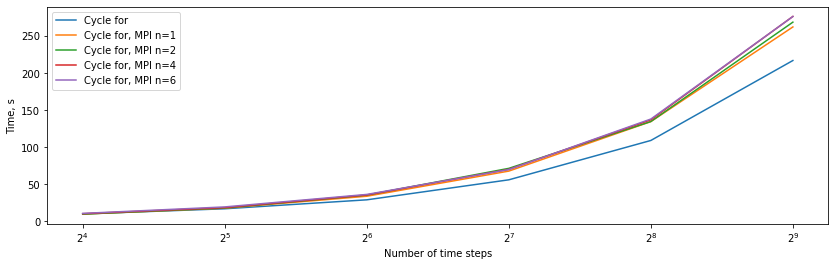

In [112]:
plt.figure(figsize=(14,4))
plt.plot(2**np.arange(4, 10), times_for, label='Cycle for')
plt.plot(2**np.arange(4, 10), times_mpi1_for, label='Cycle for, MPI n=1')
plt.plot(2**np.arange(4, 10), times_mpi2_for, label='Cycle for, MPI n=2')
plt.plot(2**np.arange(4, 10), times_mpi4_for, label='Cycle for, MPI n=4')
plt.plot(2**np.arange(4, 10), times_mpi6_for, label='Cycle for, MPI n=6')
plt.xlabel('Number of time steps')
plt.ylabel('Time, s')
plt.xscale('log', basex=2)
plt.legend();

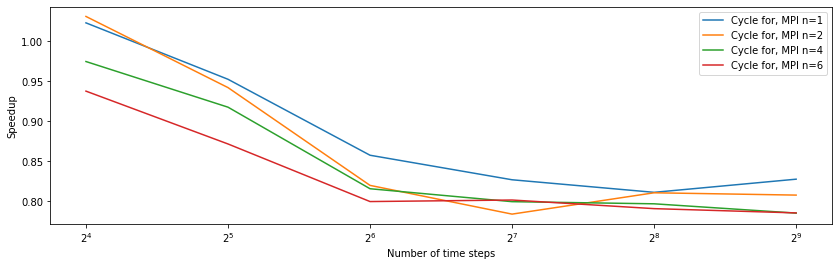

In [116]:
plt.figure(figsize=(14,4))
plt.plot(2**np.arange(4, 10), np.array(times_for)/np.array(times_mpi1_for), label='Cycle for, MPI n=1')
plt.plot(2**np.arange(4, 10), np.array(times_for)/np.array(times_mpi2_for), label='Cycle for, MPI n=2')
plt.plot(2**np.arange(4, 10), np.array(times_for)/np.array(times_mpi4_for), label='Cycle for, MPI n=4')
plt.plot(2**np.arange(4, 10), np.array(times_for)/np.array(times_mpi6_for), label='Cycle for, MPI n=6')
plt.xlabel('Number of time steps')
plt.ylabel('Speedup')
plt.xscale('log', basex=2)
plt.legend();

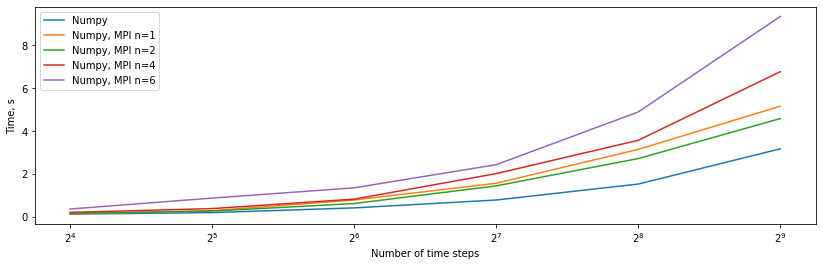

In [113]:
plt.figure(figsize=(14,4))
plt.plot(2**np.arange(4, 10), times_numpy, label='Numpy')
plt.plot(2**np.arange(4, 10), times_mpi1_numpy, label='Numpy, MPI n=1')
plt.plot(2**np.arange(4, 10), times_mpi2_numpy, label='Numpy, MPI n=2')
plt.plot(2**np.arange(4, 10), times_mpi4_numpy, label='Numpy, MPI n=4')
plt.plot(2**np.arange(4, 10), times_mpi6_numpy, label='Numpy, MPI n=6')
plt.xlabel('Number of time steps')
plt.ylabel('Time, s')
plt.xscale('log', basex=2)
plt.legend();

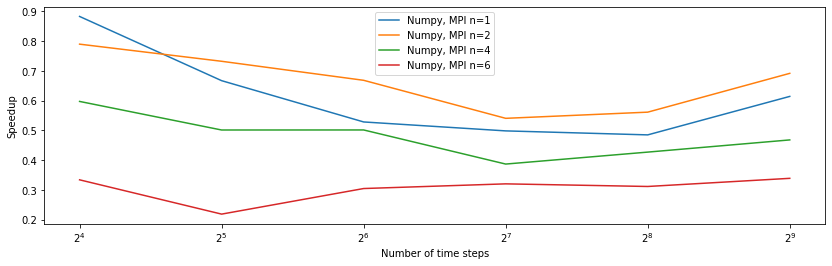

In [117]:
plt.figure(figsize=(14,4))
plt.plot(2**np.arange(4, 10), np.array(times_numpy)/np.array(times_mpi1_numpy), label='Numpy, MPI n=1')
plt.plot(2**np.arange(4, 10), np.array(times_numpy)/np.array(times_mpi2_numpy), label='Numpy, MPI n=2')
plt.plot(2**np.arange(4, 10), np.array(times_numpy)/np.array(times_mpi4_numpy), label='Numpy, MPI n=4')
plt.plot(2**np.arange(4, 10), np.array(times_numpy)/np.array(times_mpi6_numpy), label='Numpy, MPI n=6')
plt.xlabel('Number of time steps')
plt.ylabel('Speedup')
plt.xscale('log', basex=2)
plt.legend();

### Shazam

In [107]:
np.random.seed(8)
signals = []
n = 2**10
for i in range(100):
    a, f = np.random.randint(1,6,size=2)
    b, g = np.random.randint(-10, 10, size=2)
    c, h = np.random.randint(1, 3, size=2)
    d, j = np.random.randint(1, 4, size=2)
    e, k = 10 * np.random.randint(1, 4, size=2)
    signals.append(get_signal(a,b,c,d,e,f,g,h,j,k,n=n))

new_signal = get_signal(3, 0, 2, 2, 20, 1, 5, 2, 2, 20, n=n)
t = np.linspace(-20*2*np.pi, 20*2*np.pi, n)

In [108]:
bm_numpy = shazam_numpy(new_signal, signals, t)

Text(0.5, 1.0, 'Best match')

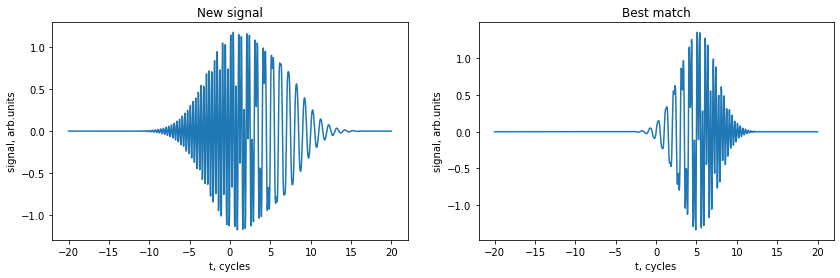

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].plot(t/2/np.pi, new_signal)
ax[0].set_xlabel('t, cycles')
ax[0].set_ylabel('signal, arb.units')
ax[0].set_title('New signal')

ax[1].plot(t/2/np.pi, signals[bm_numpy])
ax[1].set_xlabel('t, cycles')
ax[1].set_ylabel('signal, arb.units')
ax[1].set_title('Best match')